In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scanpy as sc
import snapatac2 as snap
import scipy.sparse as ssp

In [8]:
import HTSeq
import itertools
def get_TSS_pos(gtf_file):
    gtffile = HTSeq.GFF_Reader(gtf_file)
    tsspos = set()
    for feature in gtffile:
        if feature.type == "exon" and feature.attr["exon_number"] == "1":
            tsspos.add( feature.iv.start_d_as_pos )
    return tsspos

def get_TSS(bam_file, tsspos, flank):
    #gtffile = HTSeq.GFF_Reader("Homo_sapiens.GRCh38.101.gtf")
    coverage = HTSeq.GenomicArray("auto", stranded=False, typecode="i")
    for almnt in bam_file:
        if almnt.aligned:
            coverage[almnt.iv] += 1
    
    halfwinwidth = flank
    profile = np.zeros( 2*halfwinwidth, dtype='i' )      
    for p in tsspos:
        window = HTSeq.GenomicInterval( p.chrom, p.pos - halfwinwidth, p.pos + halfwinwidth, "." )
        #print(p)
        #print(window)
        try:
            wincvg = np.fromiter( coverage[window], dtype='i', count=2*halfwinwidth )
        except (IndexError):
            pass
        if p.strand == "+":
            profile += wincvg
        else:
            profile += wincvg[::-1]
    return profile

In [22]:
### Generate TSS enrichment plot
#gtf_file = '../../../../mm_hg.GRC38.gtf'
#tsspos = get_TSS_pos(gtf_file)

#bam = '../../../..final_aggregated.bam'
#profile = {}
#for i in ['ATAC']:
#    print(i)
#    profile[i] = get_TSS(HTSeq.BAM_Reader(bam), tsspos, 2000)

#TSS = profile['ATAC']/(profile['ATAC'][:100] + profile['ATAC'][-100]).mean()

### Save the data
#df = pd.DataFrame([np.arange(-halfwinwidth, halfwinwidth), (TSS/TSS.min())]).T
#df.columns = ['DNA_loc', 'TSS']
#df.to_csv('TSS_range.csv')

#### Load the data
profile = pd.read_csv('TSS_range.csv')

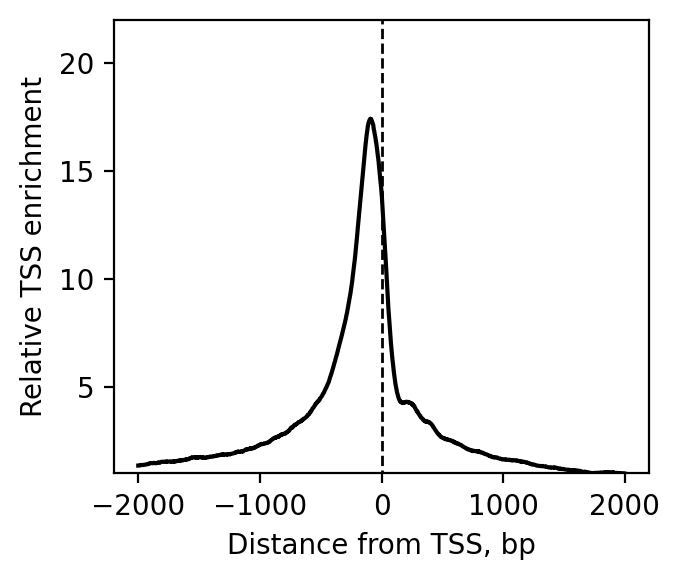

In [32]:
halfwinwidth = 2000
fig, ax = plt.subplots(figsize = (3.5,3), dpi = 200)
ax.plot(profile['DNA_loc'], profile['TSS'], c = 'Black')
    
ax.set_xlabel('Distance from TSS, bp')
ax.set_ylabel('Relative TSS enrichment')
ax.vlines(0, 0, 22, color = 'black', linewidth = 1, linestyle = '--')
ax.set_ylim(1, 22)
plt.tight_layout()


## Load fragment matrix
Generated using snap.pp.make_fragment_file('final.bam', output_file = 'fragments.tsv', barcode_tag="CB", compression='gzip')  


data = snap.pp.import_data(
    'fragments.tsv',
    chrom_sizes=chrom_sizes,
    sorted_by_barcode=False, min_num_fragments=5,
    chunk_size=2000,
    file="atac.h5ad")

snap.metrics.tsse(data, gtf_file) <br />
snap.pp.filter_cells(data, min_counts=50, min_tsse=2, max_counts=100000) <br />
snap.pp.add_tile_matrix(data, bin_size=500, counting_strategy='insertion') <br />
snap.tl.macs3(data, groupby=None) <br />
ata.uns['macs3_pseudobulk'].to_csv('peak_output.bed', sep='\t', header=False, index=False) <br />
snap.metrics.frip(data, regions = {'peaks_frac':'peak_output.bed'}) <br />


In [35]:
data = sc.read_h5ad('data/ATACseq_run/K562_L1210_L929_fragment_matrix.h5ad')

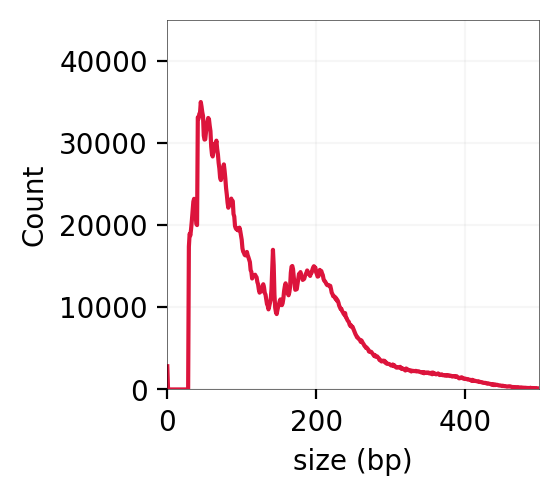

In [44]:
#Fragment size distribution
fig, ax = plt.subplots(figsize = (2.4,2.4), dpi = 200)
ax.plot([i for i in range(data.uns['frag_size_distr'].shape[0])], data.uns['frag_size_distr'], color = 'crimson')
ax.set_xlim(0, 500)
ax.set_ylim(0, 45e3)
ax.set_xlabel('size (bp)')
ax.set_ylabel('Count')
ax.grid(alpha = 0.1)

In [38]:
#Filtering for different populations
bg = data.obs['cell_type'] == 'background'
mm = data.obs['cell_type'] == 'mouse'
hs = data.obs['cell_type'] == 'human'
db = data.obs['cell_type'] == 'doublet'

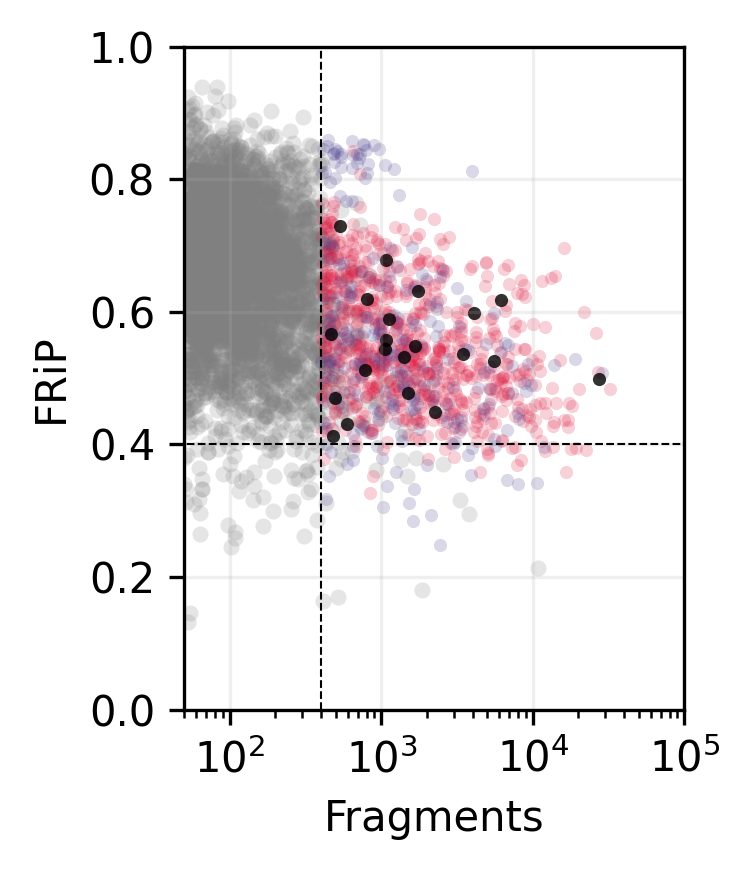

In [39]:
fig, ax = plt.subplots(figsize = (2.6,3), dpi =300)

x = data.obs['n_fragment']
y = data.obs['peaks_frac'].values

ax.scatter(x[bg], y[bg],s = 15, alpha = 0.2, c = 'grey', marker ='o', linewidth = 0, label = 'Background')
ax.scatter(x[mm], y[mm],s = 10, alpha = 0.2, c = 'crimson', marker ='o', linewidth = 0, label = 'mouse')
ax.scatter(x[hs], y[hs],s = 10, alpha = 0.2, c = 'darkslateblue', marker ='o', linewidth = 0, label = 'human')
ax.scatter(x[db], y[db],s = 10, alpha = 0.8, c = 'black', marker ='o', linewidth = 0, label = 'doublet')



ax.set_ylim(0, 1)
ax.set_xlim(50, 1e5)
ax.set_xscale('log')

ax.set_ylabel('FRiP')
ax.set_xlabel('Fragments')

ax.vlines(400, 0, ymax = 35, linestyle ='--', color = 'black', linewidth = 0.5)
ax.hlines(0.4, 1, 3e6, linestyle ='--', color = 'black', linewidth = 0.5)

ax.grid(True, alpha = 0.2)

plt.tight_layout()


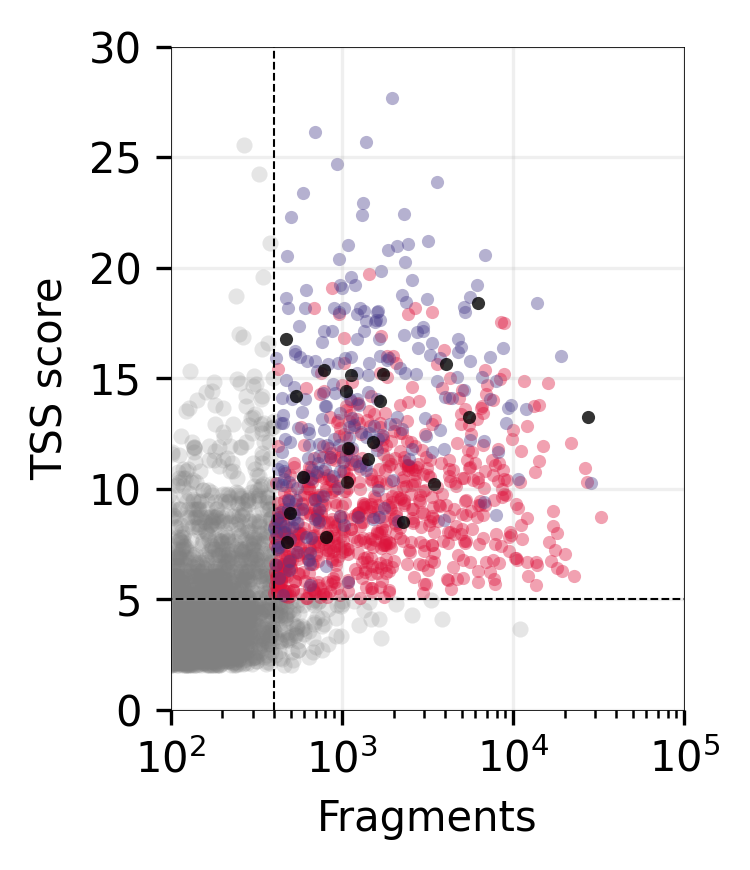

In [26]:
fig, ax = plt.subplots(figsize = (2.6,3), dpi =300)

ax.scatter(data.obs['n_fragment'][bg], data.obs['tsse'].values[bg],s = 15, alpha = 0.2, c = 'grey', marker ='o', linewidth = 0)
ax.scatter(data.obs['n_fragment'][mm], data.obs['tsse'].values[mm],s = 10, alpha = 0.4, c = 'crimson', marker ='o', linewidth = 0)
ax.scatter(data.obs['n_fragment'][hs], data.obs['tsse'].values[hs],s = 10, alpha = 0.4, c = 'darkslateblue', marker ='o', linewidth = 0)
ax.scatter(data.obs['n_fragment'][db], data.obs['tsse'].values[db],s = 10, alpha = 0.8, c = 'black', marker ='o', linewidth = 0)

ax.set_xscale('log')
ax.set_ylabel('TSS score')
ax.set_xlabel('Fragments')

ax.vlines(400, 0, ymax = 35, linestyle ='--', color = 'black', linewidth = 0.5)
ax.hlines(5, 1, 3e6, linestyle ='--', color = 'black', linewidth = 0.5)

ax.set_xlim(100, 1e5)
ax.set_ylim(0, 30)

ax.grid(True, alpha = 0.2)

plt.tight_layout()


Text(4000.0, 4000.0, '0.0213')

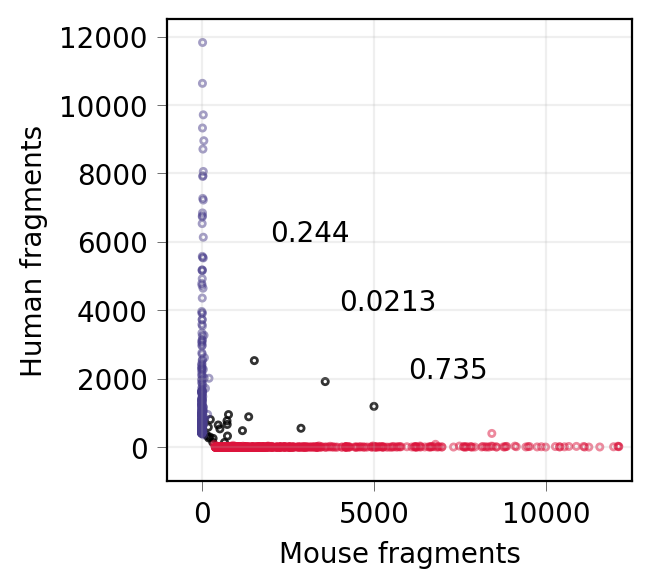

In [40]:
fig, ax = plt.subplots(figsize = (3,3), dpi = 200)

ax.scatter(data[db].obs['mm_fragments']/2, data[db].obs['hs_fragments']/2, s = 5, marker = 'o', facecolors = 'None', edgecolors='black', alpha = 0.8)
ax.scatter(data[mm].obs['mm_fragments']/2, data[mm].obs['hs_fragments']/2, s = 5, marker = 'o', facecolors = 'None', edgecolors='crimson', alpha = 0.5)
ax.scatter(data[hs].obs['mm_fragments']/2, data[hs].obs['hs_fragments']/2, s = 5, marker = 'o', facecolors = 'None', edgecolors='darkslateblue', alpha = 0.5)


ax.set_xlabel('Mouse fragments')
ax.set_ylabel('Human fragments')

ax.set_xlim(-1e3, 12.5e3)
ax.set_ylim(-1e3, 12.5e3)
plt.rcParams['axes.linewidth'] = 0.2
ax.yaxis.set_tick_params(width=0.2)
ax.xaxis.set_tick_params(width=0.2)
ax.grid(True, alpha = 0.2)

ax.text(6e3, 2e3, np.round((mm).sum()/(~(bg)).sum(), 3))
ax.text(2e3, 6e3, np.round((hs).sum()/(~(bg)).sum(), 3))
ax.text(4e3, 4e3, np.round((db).sum()/(~(bg)).sum(), 4))


### UMAP visualization

In [46]:
snap.pp.filter_cells(data, min_counts=400, min_tsse=5, max_counts=100000)

In [47]:
snap.pp.select_features(data, n_features=50000)

2025-09-07 12:53:39 - INFO - Selected 50000 features.


In [48]:
snap.pp.scrublet(data)                                                                                                                                                                                                                                  
snap.pp.filter_doublets(data) 

2025-09-07 12:53:41 - INFO - Simulating doublets...
2025-09-07 12:53:41 - INFO - Spectral embedding ...
2025-09-07 12:53:43 - INFO - Calculating doublet scores...
2025-09-07 12:53:44 - INFO - Detected doublet rate = 1.917%


In [ ]:
snap.tl.spectral(data)
snap.tl.umap(data, n_comps = 15)
snap.pp.knn(data)
snap.tl.leiden(data)
                                                                                                                                                                                                                             
                                                                                                                                                                                                                        

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
gtf_file = 'mm_hg.GRC38.gtf' #GTF file from the reference

In [ ]:
gene_matrix = snap.pp.make_gene_matrix(data, gtf_file, counting_strategy='insertion')
sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)

In [ ]:
gene_matrix = sc.read_h5ad('data/ATACseq_run/K562_L1210_L929_Gene_matrix.h5ad')

In [659]:
sc.pp.pca(gene_matrix)
sc.pp.neighbors(gene_matrix, n_neighbors=5)
sc.tl.leiden(gene_matrix, resolution=0.5)


In [735]:
sc.tl.umap(gene_matrix, n_components=10, spread=1.2, min_dist=0.35, random_state=0)

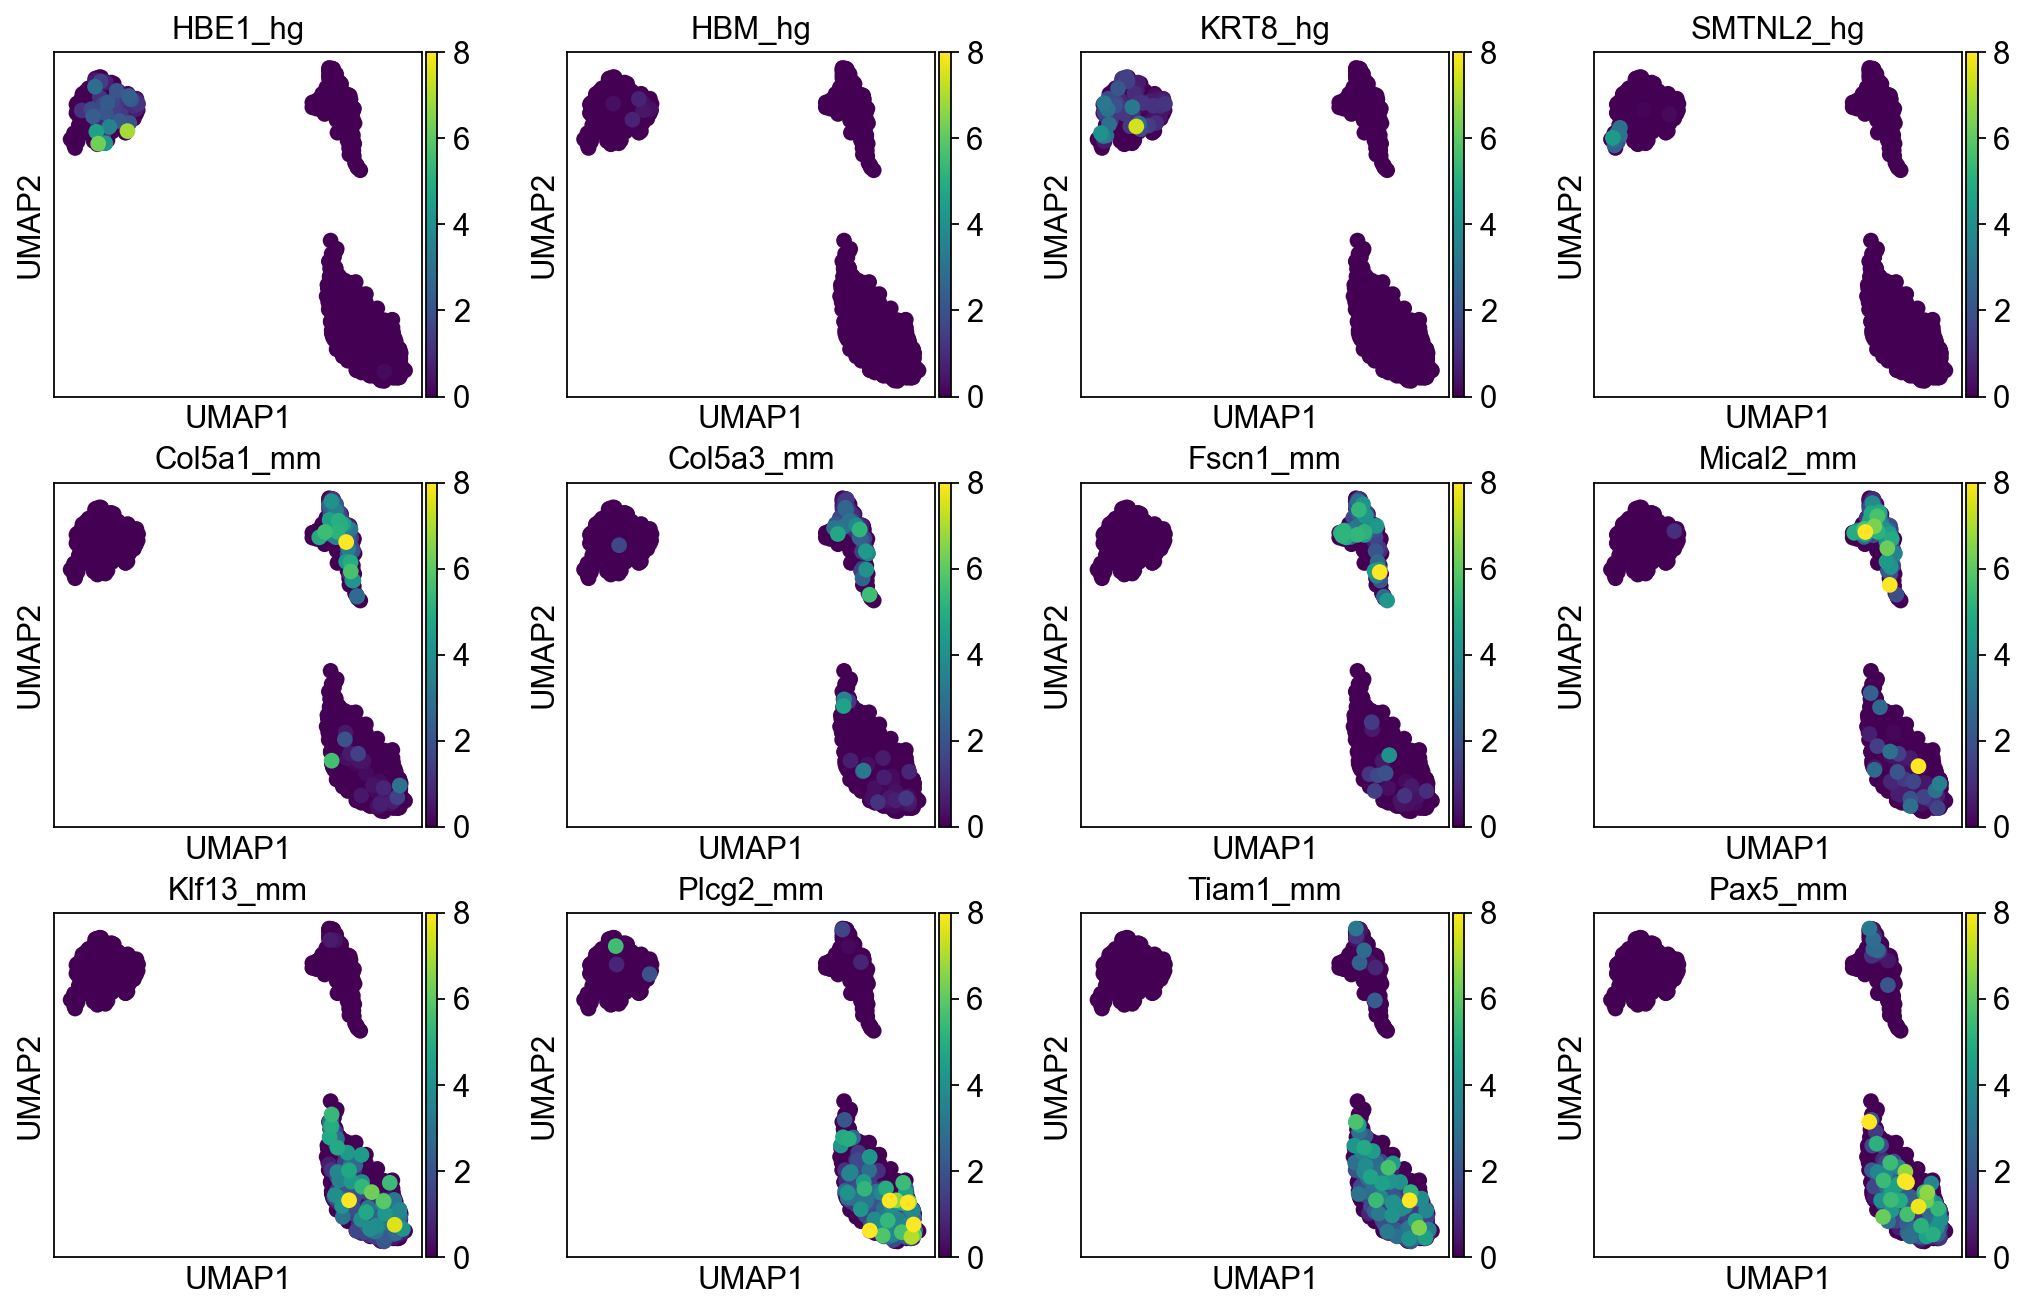

In [311]:
sc.set_figure_params(figsize=(3, 3)) 
g = ['HBE1_hg', 'HBM_hg', "KRT8_hg",'SMTNL2_hg', 'Col5a1_mm','Col5a3_mm', 'Fscn1_mm', 'Mical2_mm', 'Klf13_mm', 'Plcg2_mm', 'Tiam1_mm', 'Pax5_mm']
sc.pl.umap(gene_matrix, use_raw=False, color=g, size = 200, vmax = 8)

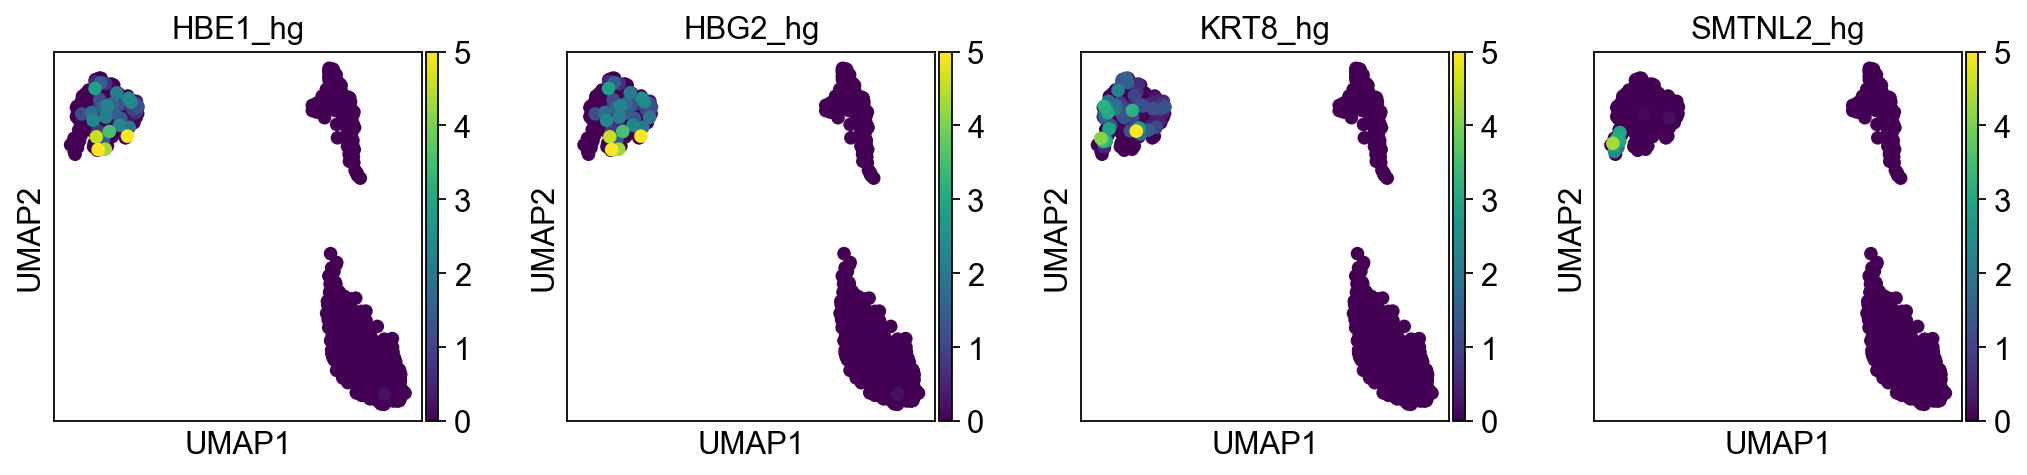

In [312]:
g = ['HBE1_hg', 'HBG2_hg', "KRT8_hg",'SMTNL2_hg']
sc.pl.umap(gene_matrix, use_raw=False, color=g, size = 150, vmax = 5, cmap = 'viridis', save = 'UMAP1.pdf')

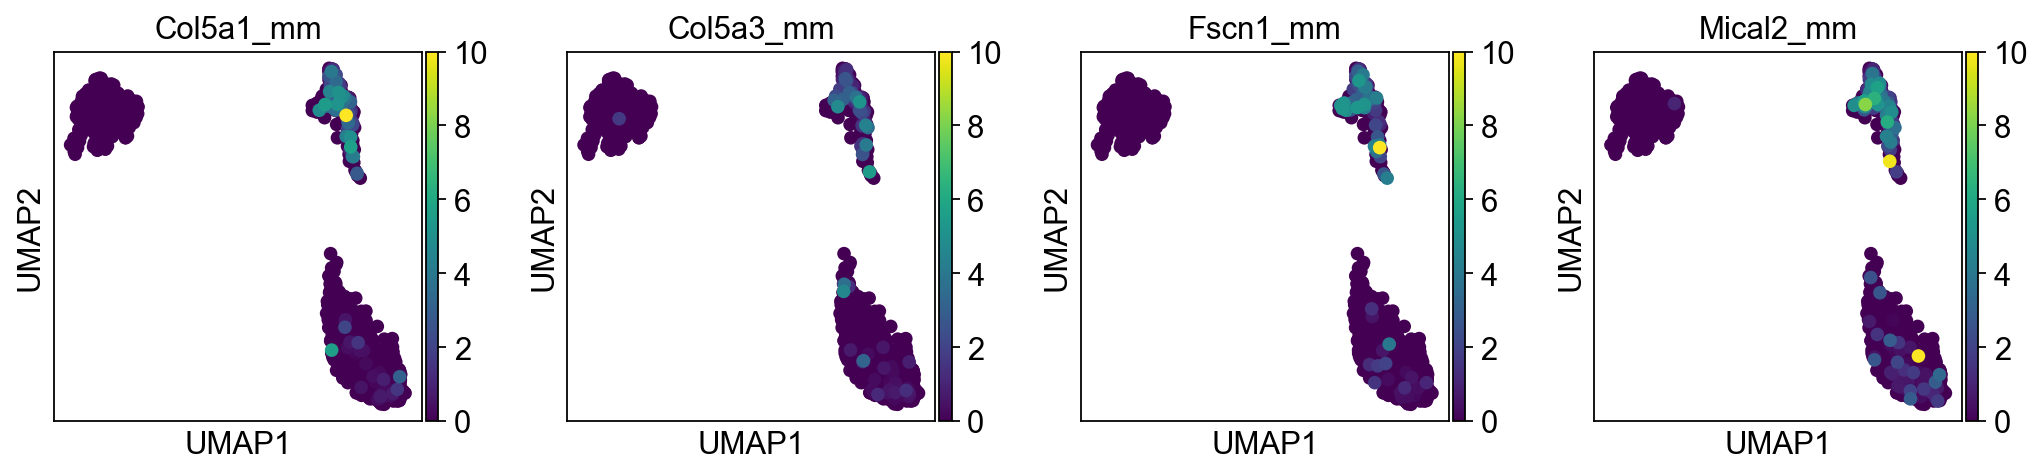

In [314]:
g = ['Col5a1_mm','Col5a3_mm', 'Fscn1_mm', 'Mical2_mm']
sc.pl.umap(gene_matrix, use_raw=False, color=g, size = 150, cmap = 'viridis', save = 'UMAP2.pdf', vmax = 10)

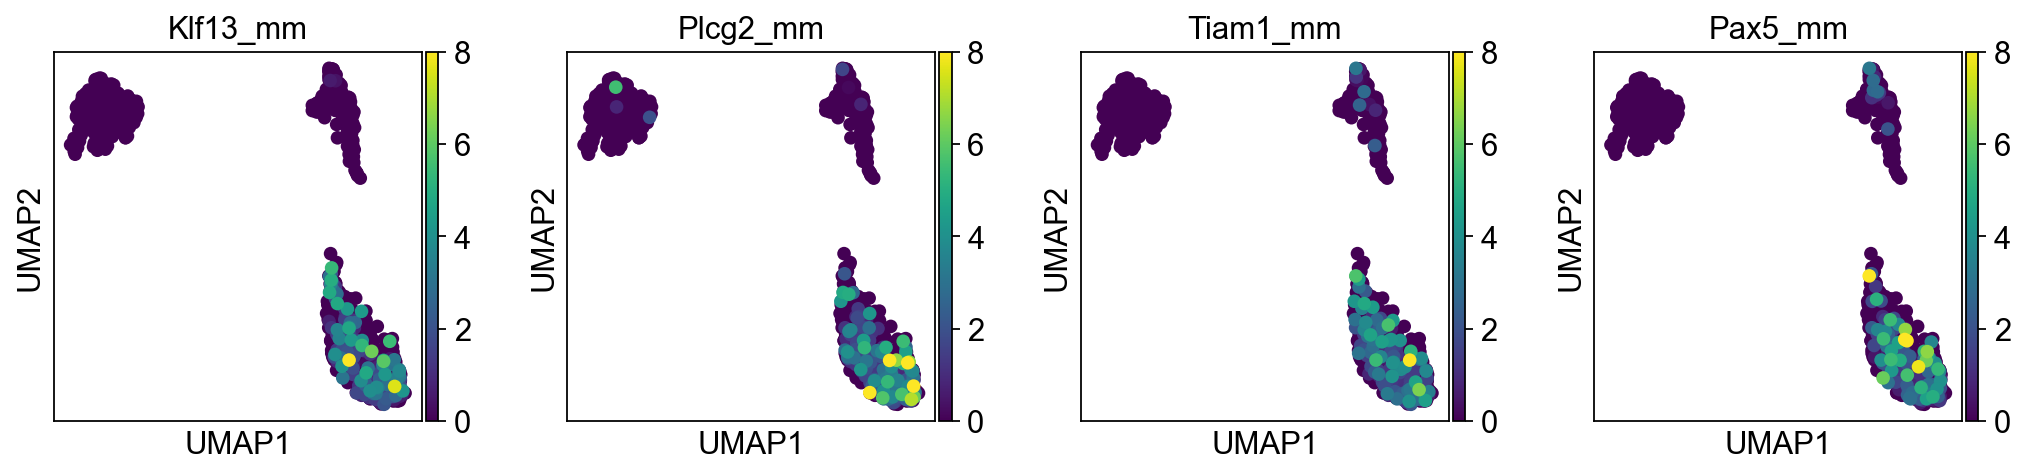

In [301]:
g = ['Klf13_mm', 'Plcg2_mm', 'Tiam1_mm', 'Pax5_mm']
sc.pl.umap(gene_matrix, use_raw=False, color=g, size = 150, vmax = 8, cmap = 'viridis', save = 'UMAP3.pdf')

In [ ]:
labels = {'0':"L1210",
 '1':"K562",
 '2':"L929",
 '3':"L1210",
 '4':"L1210",
 '5':"L929",
 '6':"K562",}

gene_matrix.obs['cell_type'] = (
    gene_matrix.obs['leiden']
    .map(labels)
    .astype('category')
)


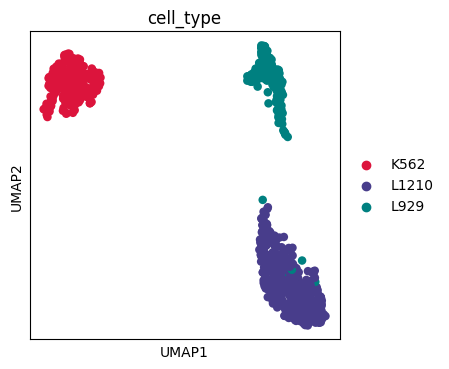

In [293]:

g = ['cell_type']
fig, ax = plt.subplots(figsize = (4,4))
sc.pl.umap(gene_matrix, use_raw=False, color=g, size = 150, palette= ['crimson', 'darkslateblue', 'teal'], vmax = 8,ax = ax)